In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info.operators import Operator, Pauli
import networkx as nx
from qiskit import Aer
import time
import warnings
import scipy
warnings.filterwarnings("ignore")
Z = Pauli('Z')
Z=Operator(Z)
I=Pauli('I')
I=Operator(I)

# 自动随机生成网格及相应边长
使用networkx作为研究工具

生成方法，给定节点数，每两个节点有一定概率相互连接，若连接，就自动生成一个边长


In [2]:
def random():
    weight=np.random.random()
    return weight
def origin_generator(n):
    G=nx.Graph()
    for i in range(0,n):
        G.add_node(i)
    for i in range(0,n):
        for j in range(i+1,n):
            if random()>0.4:
                a=random()
                #print(a)
                G.add_edge(i,j,length=a)
            else:
                continue
    return G
def draw(G):
    nx.draw(G, with_labels=True, node_color='b')

# 自动构建量子线路
qiskit

In [3]:
def QAOA_circuit(n,beta,gamma,p,EVdata):
    cir = QuantumCircuit(n)
    for i in range(0,n):
            cir.h(i)
    for j in range(0,p):        
        for qi,qj,k in EVdata:
            cir.cx(qi,qj)
            cir.rz(2*gamma[j]*k,qj)
            cir.cx(qi,qj)
        for i in range(0,n):
            cir.rx(2*beta[j],i)    
    cir.measure_all()
    return cir
    
    

In [4]:
def const_origin(p):#这个没有用上
    origin=[]
    for i in range(0,p):
        origin.append(random())
        origin.append(random())
    return origin    

In [5]:
def simi_result(circuit):#进行实验测量
    simulator = QasmSimulator()
    compiled_circuit = transpile(circuit, simulator)
    job = simulator.run(compiled_circuit, shots=500)
    result = job.result()
    counts = result.get_counts(compiled_circuit)
    return counts
    
    

In [6]:
def EVcut(EVdata):#图数据转换为处理的问题，量子比特与边长
    first=[]
    second=[]
    length=[]
    for i,j,k in EVdata:
        first.append(i)
        second.append(j)
        length.append(k)
    return first,second,length
        

In [7]:
def classic(n,EVdata):
    group=[]
    v=2**n
    for i in range(0,v):
        str1=str(bin(i))
        str2=str1.lstrip('0b')
        str3=str2.rjust(n,'0')
        group.append(str3)
    value=classic_expectations(EVdata)
    indexmax=value.index(max(value))
    #print(group)
    #print('true_result',group[indexmax])
    #print(max(value))
    return max(value)
def classic_expectations(EVdata):
    v=2**n
    group=[]
    for i in range(0,v):
        str1=str(bin(i))
        str2=str1.lstrip('0b')
        str3=str2.rjust(n,'0')
        group.append(str3)
    total=0
    total1=[]
    first,second,length=EVcut(EVdata)
    for j in range(0,len(group)):
        for i in range(0,len(first)):
            if group[j][first[i]]!=group[j][second[i]]:
                temp=length[i]
                total=total+temp
                #print("yeah")
            else:
                temp=0
                total=total+temp
        total1.append(total)
        total=0
    return total1

In [8]:
def expectations(EVdata,counts):#求取期望
    group=list(counts.keys())
    values=list(counts.values())  
    total=0
    total1=0
    first,second,length=EVcut(EVdata)
    for j in range(0,len(group)):
        for i in range(0,len(first)):
            if group[j][first[i]]!=group[j][second[i]]:
                temp=length[i]
                total=total+temp
                #print("yeah")
            else:
                temp=0
                total=total+temp
        total1=float(values[j])*total/500+total1
        total=0
    return total1
def maxget(EVdata,counts):
    group=list(counts.keys())
    values=list(counts.values())
    first,second,length=EVcut(EVdata)
    indexmax=values.index(max(values))
    maxnum=group[indexmax]
    total=0
    for i in range(0,len(first)):
        if maxnum[first[i]]!=maxnum[second[i]]:
            temp=length[i]
            total=total+temp
            #print("yeah")
        else:
            temp=0
            total=total+temp
    #print("最大分割",maxnum)
    #print("最大分割值",total)
    return total

# 算法实现
这里使用的是贝叶斯优化器来进行调参，随着步数p的深入，自动生成对应参数数量的优化器

无梯度优化

In [9]:
def optifun(x):
    x=list(x)
    beta=[]
    gamma=[]
    for i in range(0,p):
        beta.append(x[i])
    for j in range(0,p):
        gamma.append(x[j+p])
    cir=QAOA_circuit(n,beta,gamma,p,EVdata)
    counts=simi_result(cir)
    exp=expectations(EVdata,counts)
    return -exp    
#def optimiaztion(): 

In [10]:
def bounds(p):
    a=(0,np.pi)
    b=(0,np.pi)
    bnd=[]
    for i in range(0,p):
        bnd.append(a)
    for j in range(0,p):
        bnd.append(b)
    bnd=tuple(bnd)
    return bnd
def main(n,p):
    x0=np.array(const_origin(p))
    bnd=bounds(p)
    result=scipy.optimize.minimize(optifun,x0,method='COBYLA',bounds=bnd)
    #print(result)
    #print(result.x)
    pa=list(result.x)
    beta=[]
    gamma=[]
    for i in range(0,p):
        beta.append(pa[i])
    #print(beta)
    for j in range(0,p):
        gamma.append(pa[j+p])
    #print(gamma)
    cirfinal=QAOA_circuit(n,beta,gamma,p,EVdata)
    counts=simi_result(cirfinal)
    #print(counts)
    a=maxget(EVdata,counts)
    return a,counts
    

# 结果输出

问题
节点 0 3 长度 0.9137442861668003
节点 1 3 长度 0.6500621380176358


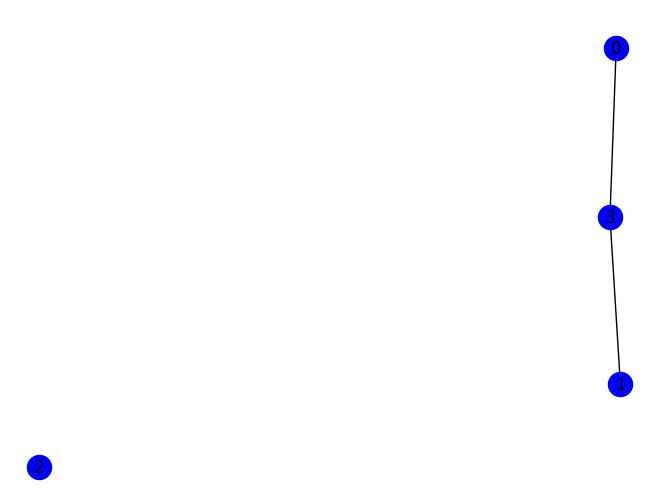

In [11]:
n=4
p=1
G=origin_generator(n)
draw(G)
EVdata = G.edges(data="length")
print("问题")
for i,j,k in EVdata:
    print("节点",i,j,"长度",k)

# 经典

In [12]:
classic(n,EVdata)

1.563806424184436

In [13]:
re,counts=main(n,p)
print(re)

1.563806424184436


In [14]:
def aqtest(a,b):
    global n
    global p
    n=a
    p=b    
    count=0
    for i in range(0,100):
        #print("当前进度",i)
        G=origin_generator(n)
        global EVdata
        EVdata = G.edges(data="length")
        max1=classic(n,EVdata)
        max2,counts=main(n,p)
        #print(max1,max2)
        if max1==max2:
            count=count+1
    print("FINAL ACCURACY",count)
    return count 

In [15]:
list1=[]
for nn in range(1,6):
    print(nn)
    count=aqtest(4,nn)
    list1.append(count)

1
FINAL ACCURACY 55
2
FINAL ACCURACY 52
3
FINAL ACCURACY 57
4
FINAL ACCURACY 51
5
FINAL ACCURACY 54


In [19]:
list1=[]
for nn in range(3,10):
    print(nn)
    count=aqtest(nn,2)
    list1.append(count)

3
FINAL ACCURACY 47
4
FINAL ACCURACY 67
5
FINAL ACCURACY 15
6
FINAL ACCURACY 20
7
FINAL ACCURACY 9
8
FINAL ACCURACY 11
9
FINAL ACCURACY 1


In [21]:
aqtest(4,2)

1.720515573227382 0.911728404169274
1.5765831260897185 1.5765831260897185
1.2334472319345235 0.21208934671064839
1.8053008173510672 1.8053008173510672
1.6588812718850323 1.6588812718850323
0.674798271317962 0.674798271317962
3.395849927871901 3.395849927871901
0.9582005212280946 0.9582005212280946
1.380407738414509 1.380407738414509
2.0048550982112605 2.0048550982112605
1.728918304101485 1.666729749670378
1.5350938788419546 0.7521481547515347
1.4150931143970529 1.4150931143970529
0.7078953251223455 0.7078953251223455
1.9070873912877446 1.729317922821966
2.6140287419915404 2.6140287419915404
1.8436531236726692 1.8436531236726692
0.8809401307352177 0.8809401307352177
2.7236912464342 2.7236912464342
1.0919065693195613 1.0919065693195613
0.7962654818209676 0.49874732548494394
1.5718624688854028 1.0515503144946219
1.0345123729079286 1.0345123729079286
2.037751169040946 2.037751169040946
1.8204883902713886 1.8204883902713886
1.5268156705146505 1.454559549971437
2.1869320100561502 2.186932010

70